In [1]:
# importing packages and modules
import numpy as np
import jax.numpy as jnp
#import autograd.numpy as jnp
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize, check_grad
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from scipy.stats import multivariate_normal, norm
from jax import value_and_grad
#from autograd import value_and_grad

sns.set_context("talk")

In [2]:
# setting hyperparameters
S = 20 # sessions
T = 1000 # trials per session
N = T * S # total data points
C = 2 # classes
K = 2 # states
D = 2 # features (sensory & bias)

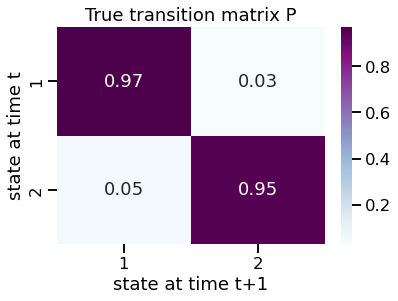

In [3]:
# True Transition Matrix
trueP = np.zeros((2,2))
trueP[0,0]=0.97
trueP[0,1]=0.03
trueP[1,0]=.05
trueP[1,1]=.95
plot_transition_matrix(trueP, title='True')

In [4]:
# true intial latent state distribution
truepi = np.ones((K))/K
print(truepi)

[0.5 0.5]


Session indicies
[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000]
(20000, 2, 2, 2)


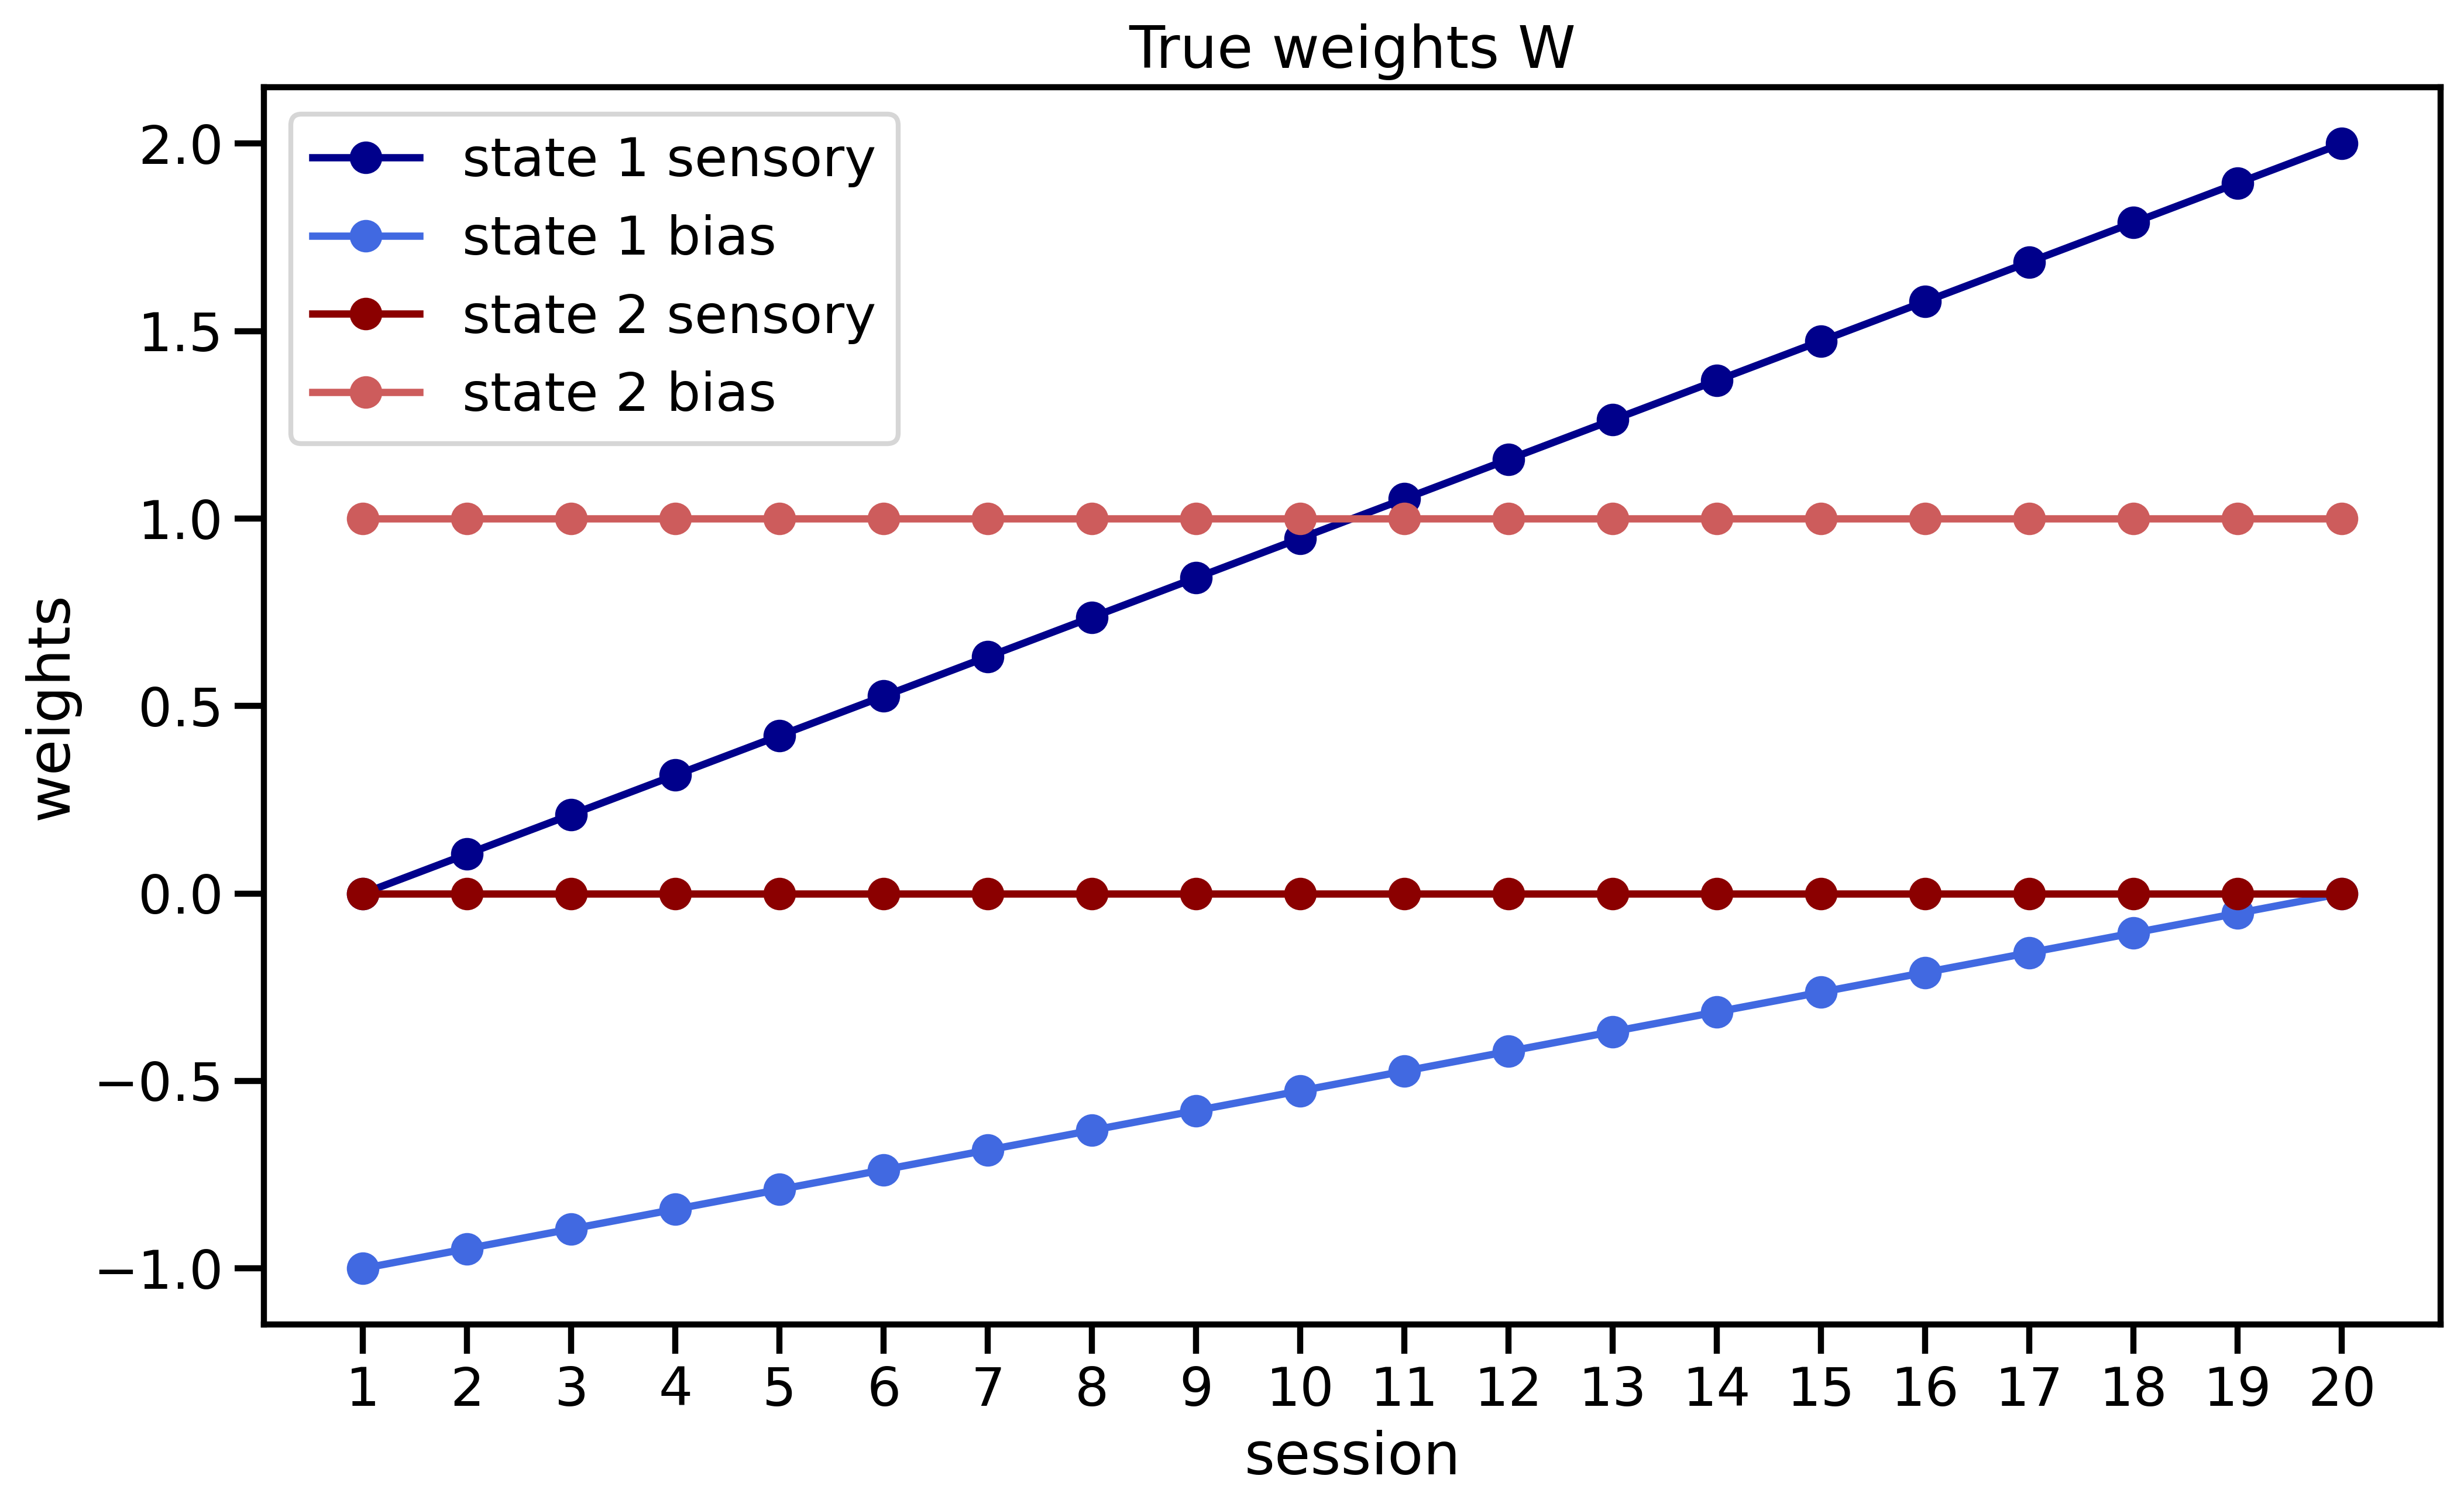

In [5]:
# True Weights and Session Start Indices
ourW = np.zeros((S,K,D))
ourW[:,0,1] = np.linspace(0,2,S) # state 1 sensory (increasing)
ourW[:,0,0] = np.linspace(-1,0,S) # state 1 bias (decreasing)
ourW[:,1,1] = 0 # state 2 sensory (flat 0)
ourW[:,1,0] = 1 # state 2 bias (flat 1)
trueW = np.zeros((N,K,D,C))
# change weight format to have session*trials points
sessInd = []
for sess in range(0,S):
    sessInd.append(sess*T)
    for t in range(0,T):
        trueW[sess*T+t,:,:,1] = ourW[sess,:,:]
sessInd.append(N)
print("Session indicies")
print(sessInd)

print(trueW.shape)
fig, axes = plt.subplots(1, figsize = (12,7), dpi=400)
plotting_weights(w=trueW, sessInd=sessInd, axes=axes, trueW=None, title='True weights W', save_fig=False)

In [8]:
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
# x, y, _ = dGLM_HMM.simulate_data(trueW, trueP, truepi, sessInd, save=True, title=f'/N={N}_{K}_state_constant-drift_')
x = np.load(f'../data_M1/N={N}_{K}_state_constant-drift_x.npy')
y = np.load(f'../data_M1/N={N}_{K}_state_constant-drift_y.npy')

In [10]:
splitFolds = 5
presentTrain, presentTest = split_data(N, sessInd, folds=5, blocks=10, random_state=1)

In [22]:
sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,1,0.5,dtype=float))] + [2**x for x in list(np.arange(1,8,2,dtype=float))]
maxiter = 250
fit_init_states=False

allP = np.zeros((splitFolds, len(sigmaList), K, K))
allpi = np.zeros((splitFolds, len(sigmaList), K))
allW = np.zeros((splitFolds, len(sigmaList), N, K, D, C))
# trainLl = np.zeros((splitFolds, len(sigmaList), maxiter))
testLl = np.zeros((splitFolds, len(sigmaList)))
testAccuracy = np.zeros((splitFolds, len(sigmaList)))

# fitting
for fold in range(0, splitFolds):
    allP[fold], allpi[fold], allW[fold], _, testLl[fold], testAccuracy[fold] = fit_eval_CV_multiple_sigmas(K, x, y, sessInd, presentTrain[fold], presentTest[fold], sigmaList=sigmaList, maxiter=maxiter, glmhmmW=None, glmhmmP=None, L2penaltyW=1, priorDirP=None, fit_init_states=fit_init_states)

# saving
for fold in range(0, splitFolds):
    np.save(f'../data_M1/N={N}_{K}_P_simulated_data', allP)
    if (fit_init_states==True):
        np.save(f'../data_M1/N={N}_{K}_pi_simulated_data', allpi)
    np.save(f'../data_M1/N={N}_{K}_W_simulated_data', allW)
    np.save(f'../data_M1/N={N}_{K}_testLl_simulated_data', testLl)
    np.save(f'../data_M1/N={N}_{K}_testAccuracy_simulated_data', testAccuracy)




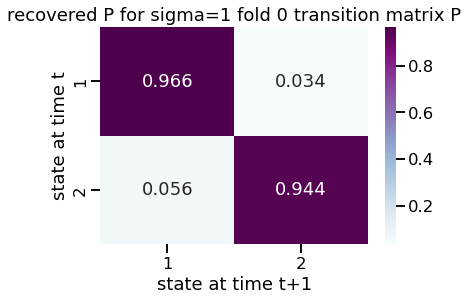

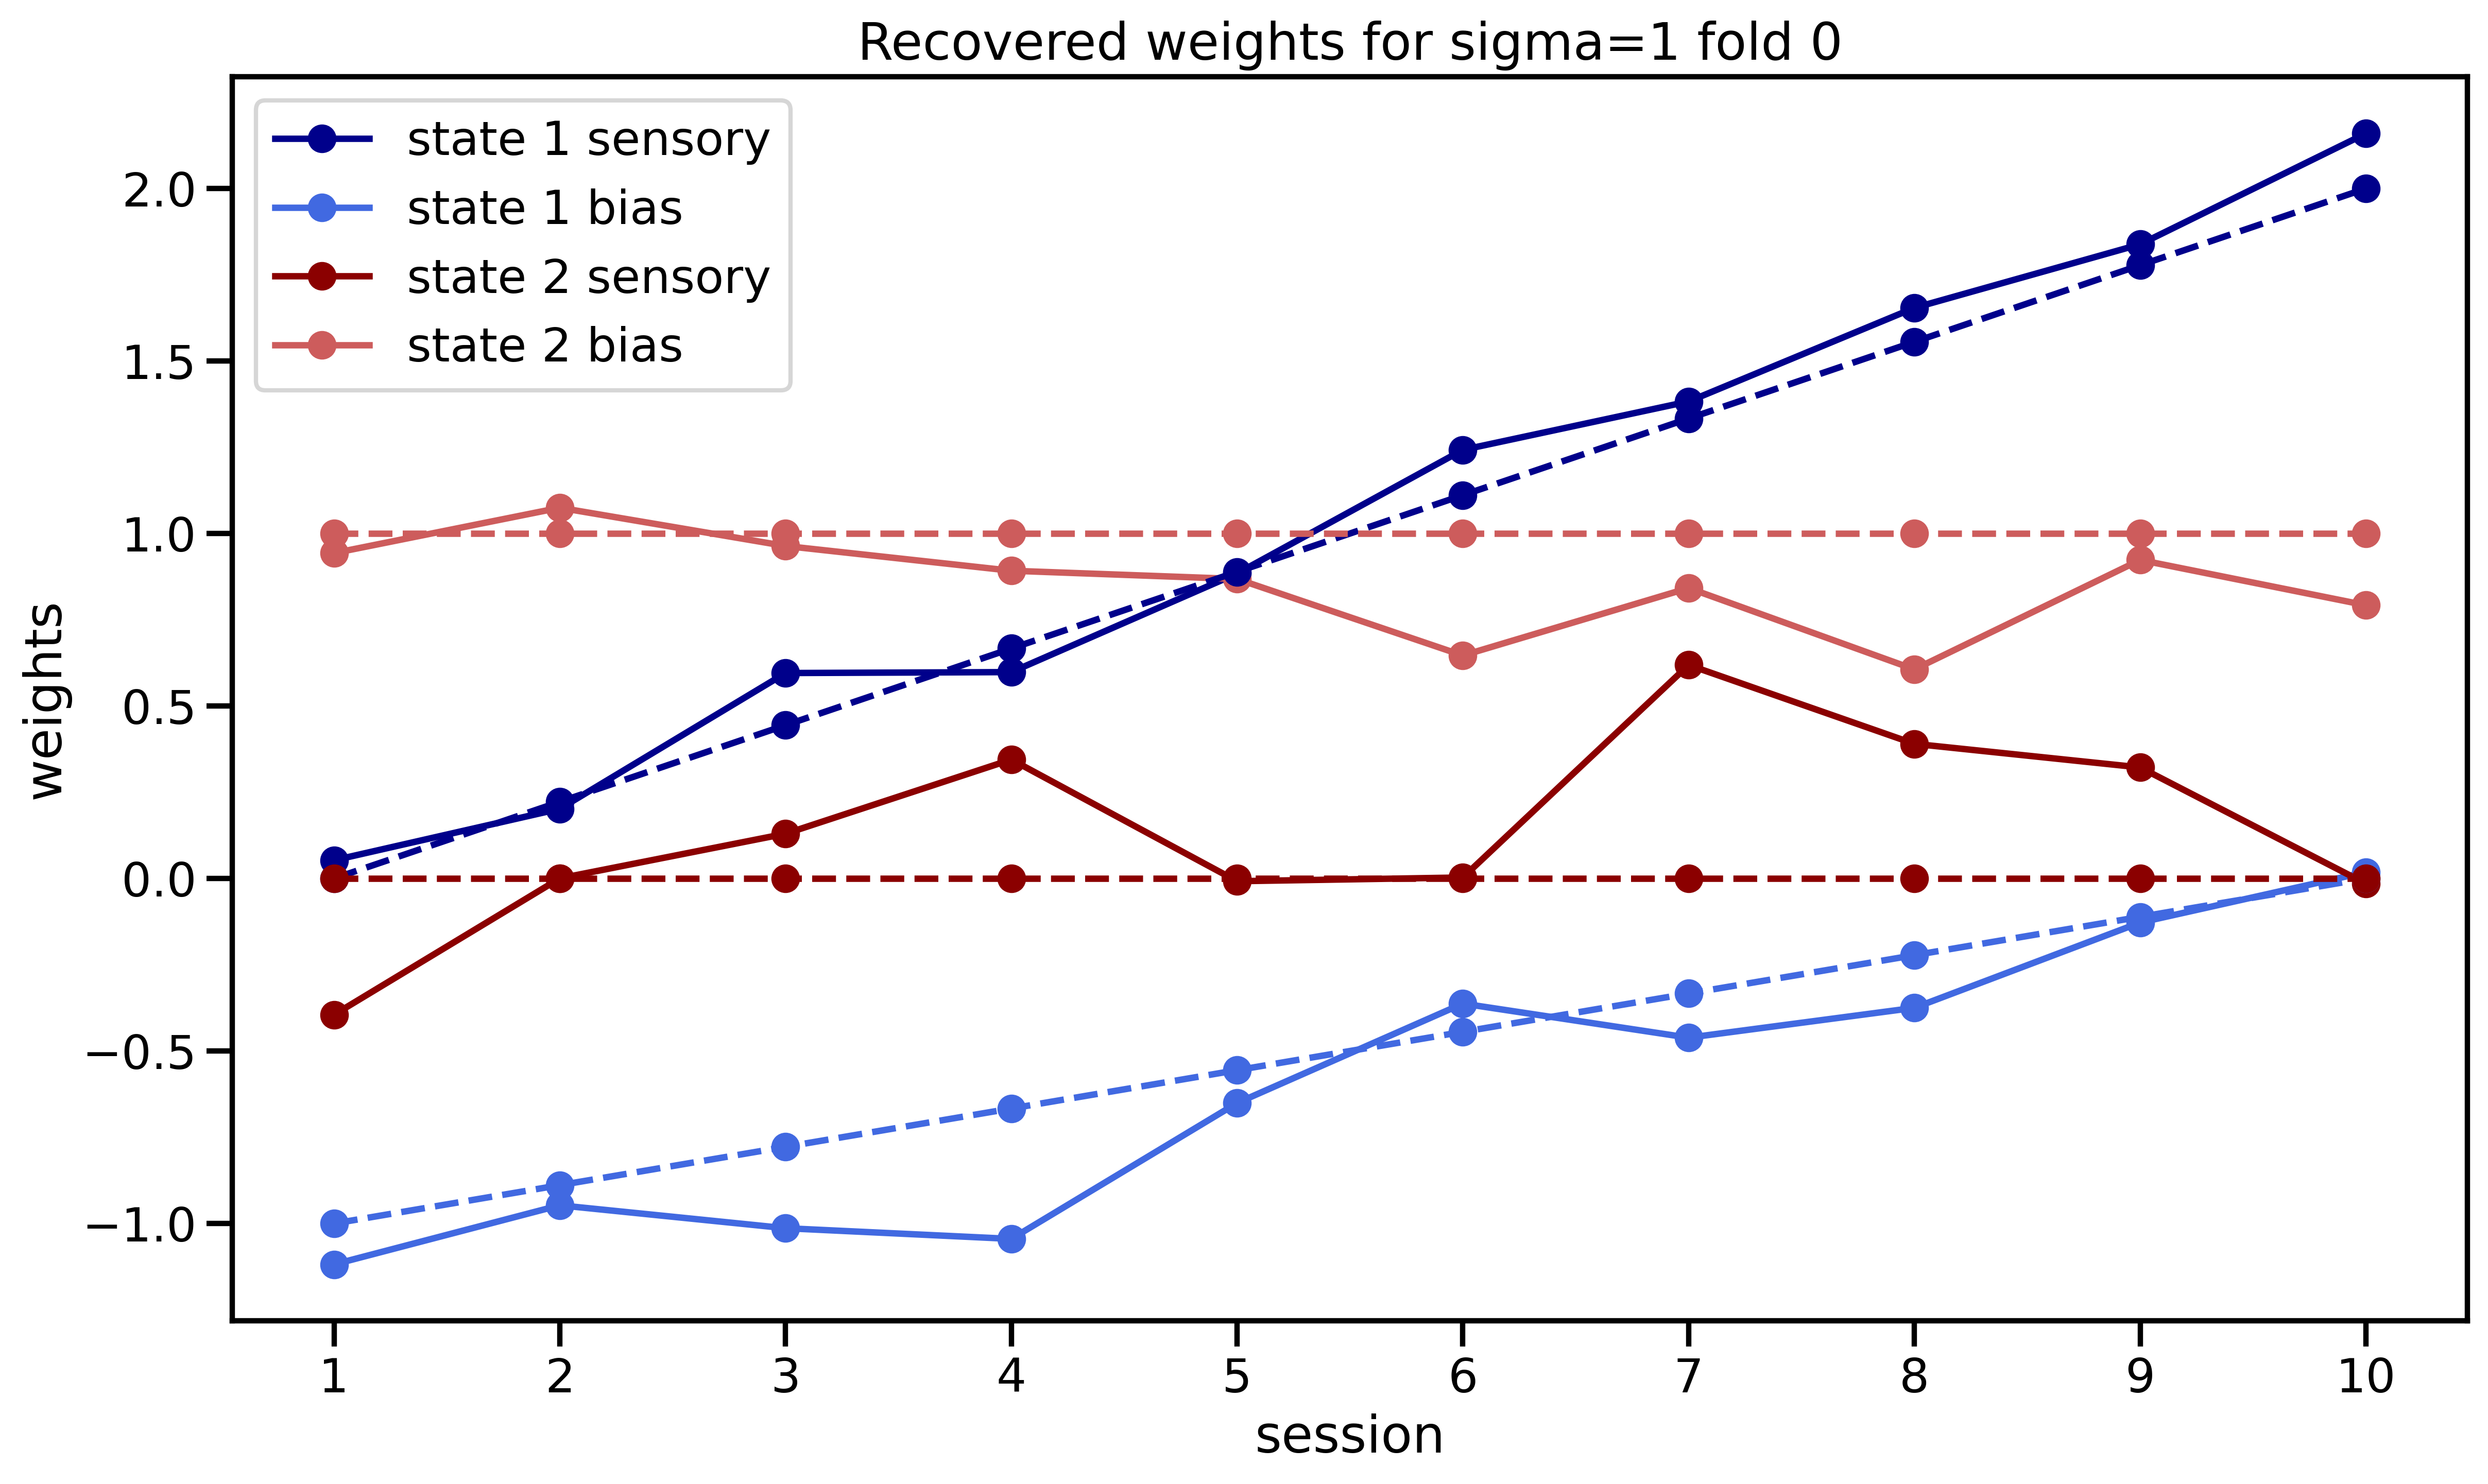

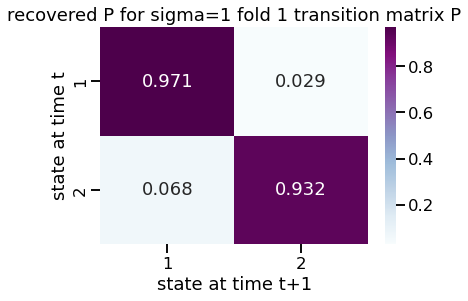

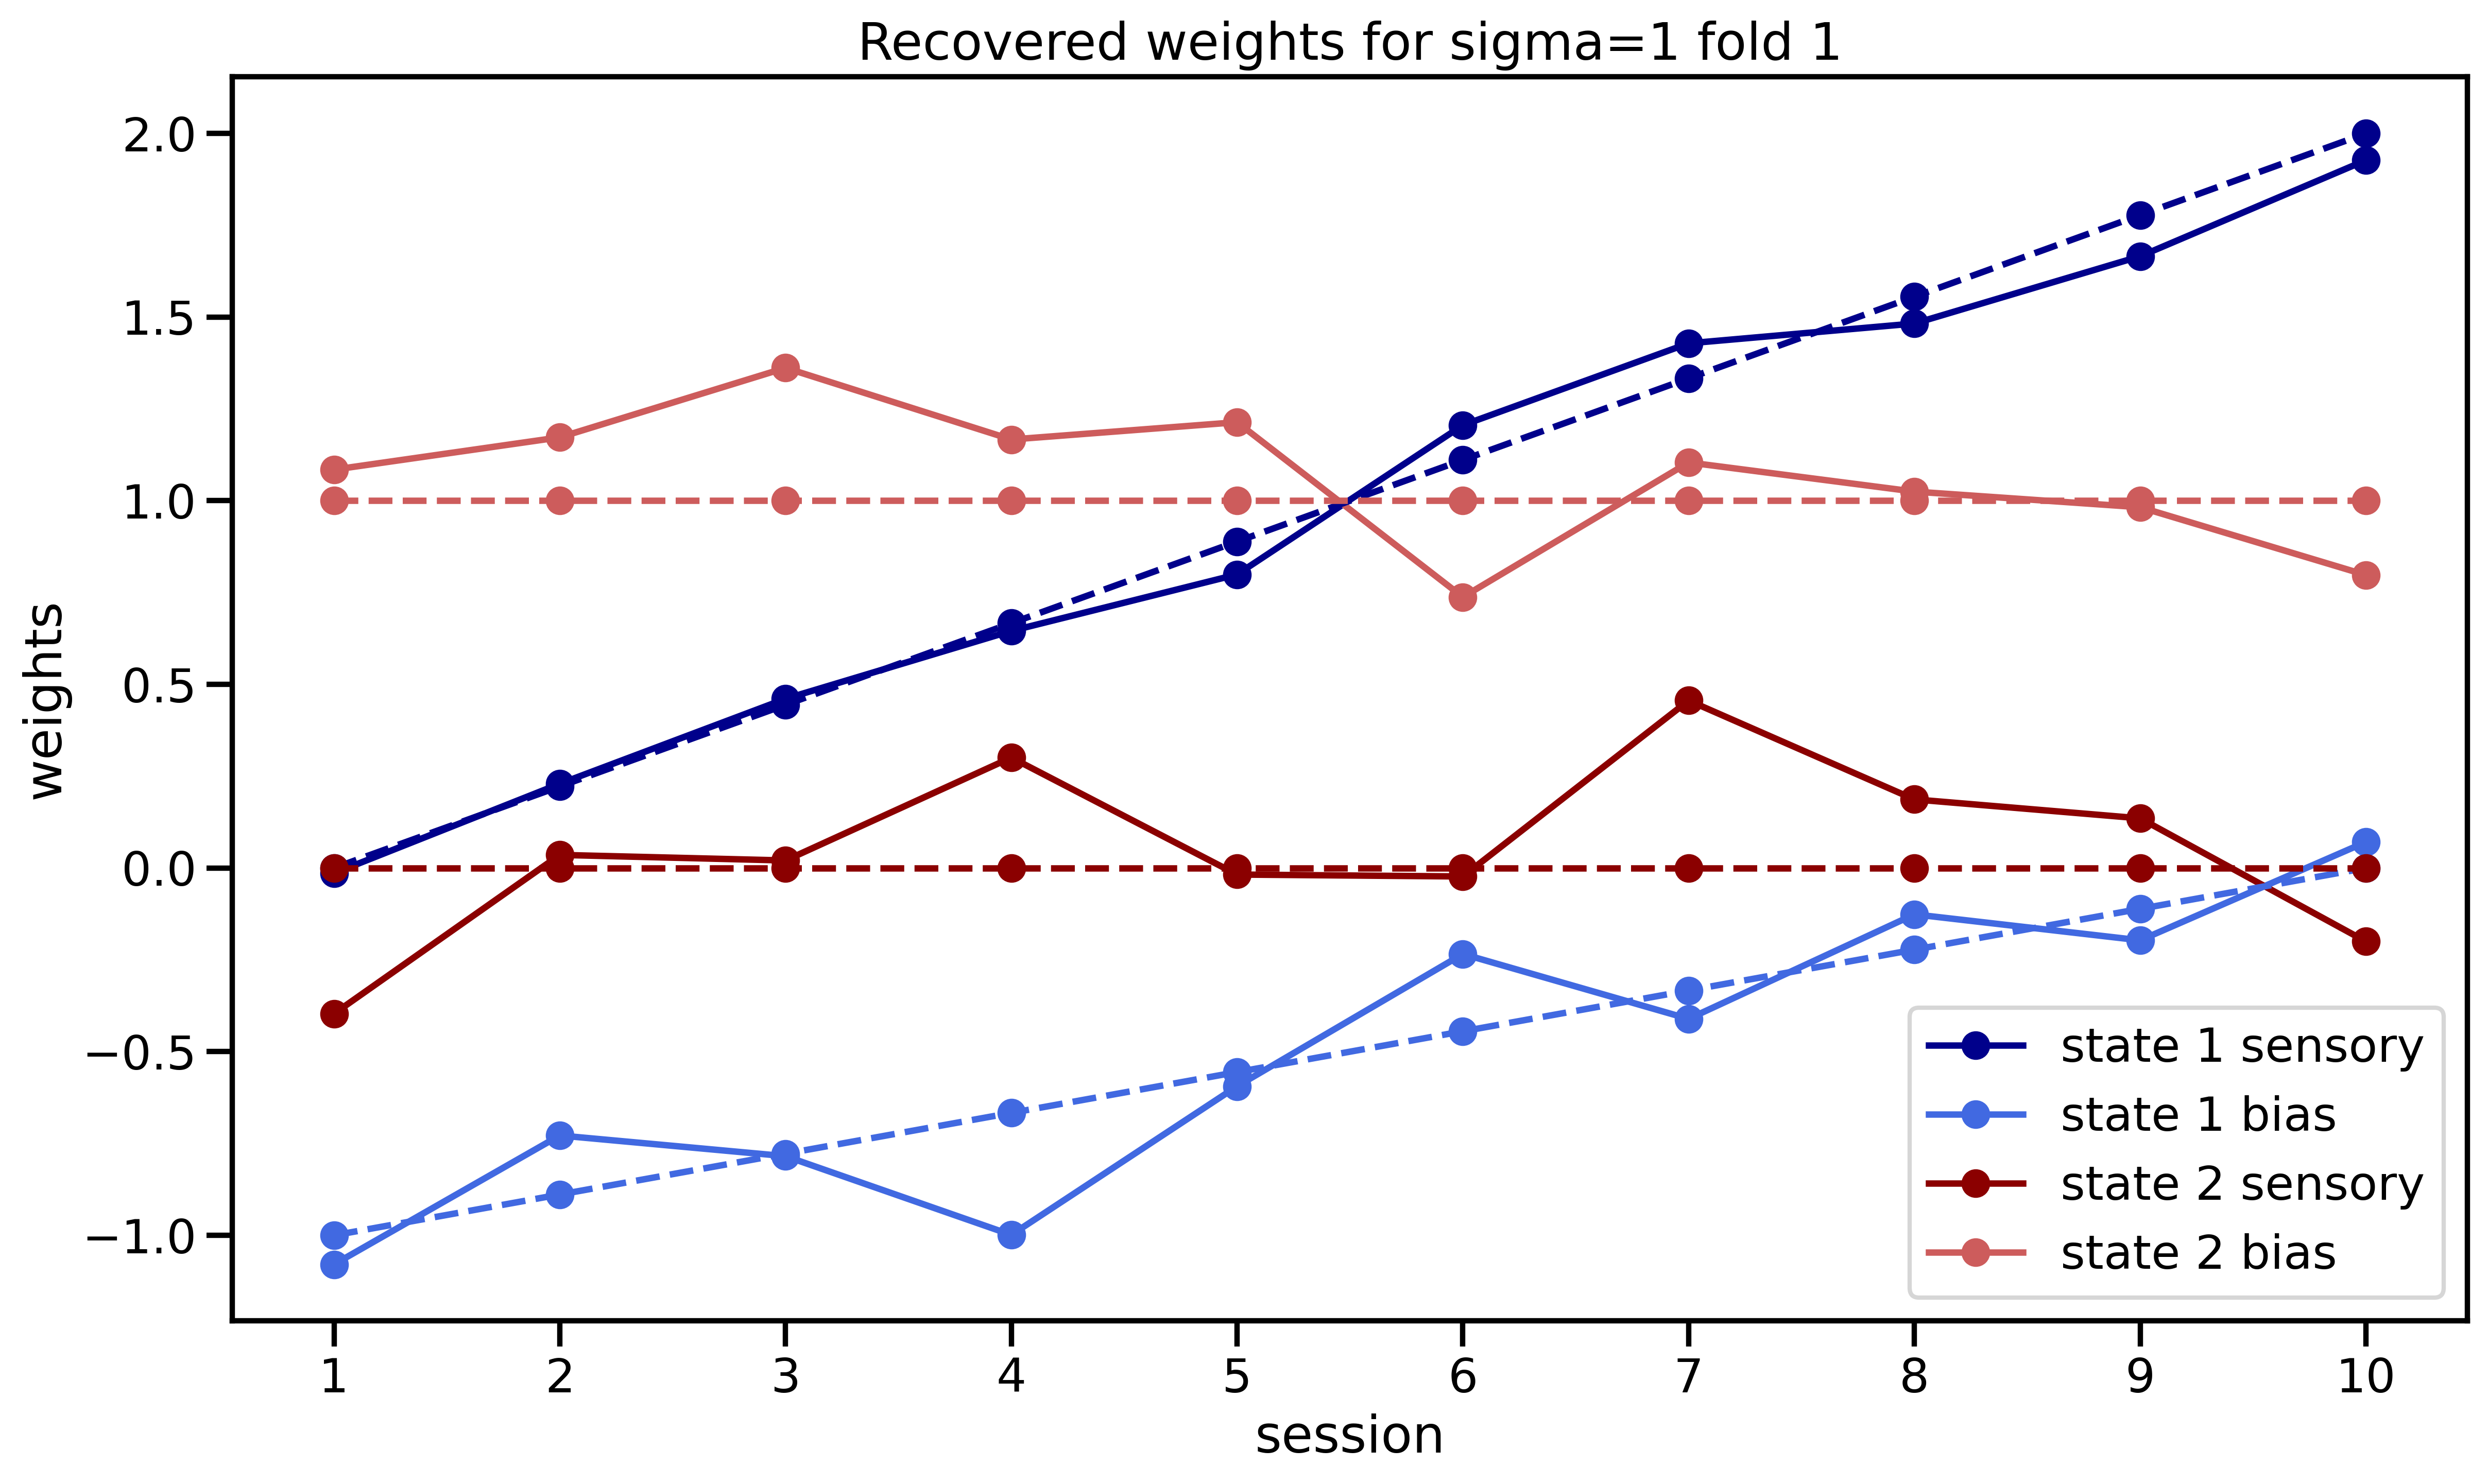

In [23]:
indSigma = 1
for fold in range(0, splitFolds):
    sortedStateInd = get_states_order(allW[fold, indSigma], sessInd, stimCol=[1])
    fig, axes = plt.subplots()
    plot_transition_matrix(allP[fold, indSigma], f'recovered P for sigma={np.round(sigmaList[indSigma],2)} fold {fold}', sortedStateInd=sortedStateInd)
    fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
    plotting_weights(allW[fold, indSigma], sessInd, axes=axes,  trueW=trueW, title=f'Recovered weights for sigma={np.round(sigmaList[indSigma],2)} fold {fold}', save_fig=False, sortedStateInd=sortedStateInd)